<a href="https://colab.research.google.com/github/harshiitsingh/Hacktoberfest-2022/blob/hacktoberfest/Pneumonia-Detection-from-Chest-X-Ray-Images/Chest_X_Ray_Classification_(Pneumonia_Normal).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection

- The dataset that we are going to use for the image classification is Chest X-Ray images, which consists of 2 categories, Pneumonia and Normal.
- Dataset Link: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images


### Dataset Description:
-  The data set is organised into 3 folders (train, test, val) and contains subfolders for each image category Opacity(viz. Pneumonia) & Normal.

```
Total number of observations (images): 5,856
Training observations: 4,192 (1,082 normal cases, 3,110 lung opacity cases)
Validation observations: 1,040 (267 normal cases, 773 lung opacity cases)
Testing observations: 624 (234 normal cases, 390 lung opacity cases)
```

## 1. Kaggle initialization and fetch dataset

Installing the needed libraries and uploading the kaggle auth json file.

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


Downloading the dataset from the kaggle API - [Pneumonia X-Ray Images](https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:04<00:00, 333MB/s]
100% 1.14G/1.14G [00:04<00:00, 250MB/s]


Unzip the downloaded dataset and move to the desired target folder using the zipfile library

In [ ]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

## 2. Basic imports and parameters

In [ ]:
# Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 32

#The dimension of the images we are going to define is 500x500 
img_height = 400
img_width = 400
# The dimension size of 500 or more than 500 with batch size greater than 16 may result 
# in a crash as the RAM gets completely used in such cases.
# A lower dimension size with greater batch size is one of the options to try.

## 3. Preparing the Data
#### 3.1 Data Augmentation
We will increase the size of the image training dataset artificially by performing some Image Augmentation technique.

```Image Augmentation expands the size of the dataset by creating a modified version of the existing training set images that helps to increase dataset variation and ultimately improve the ability of the model to predict new images.```

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  # rotation_range=40,
                                  # width_shift_range=0.2,
                                  # height_shift_range=0.2,
                                  rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  # fill_mode='nearest'          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)


# These transformation techniques are applied randomly to the images, except for the rescale. All images have been rescaled.

#### 3.2 Loading the Images
The Image Data Generator has a class known as flow from directory to read the images from folders containing images. Returns the DirectoryIterator type ```tensorflow.python.keras.preprocessing.image.DirectoryIterator```.

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, # setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


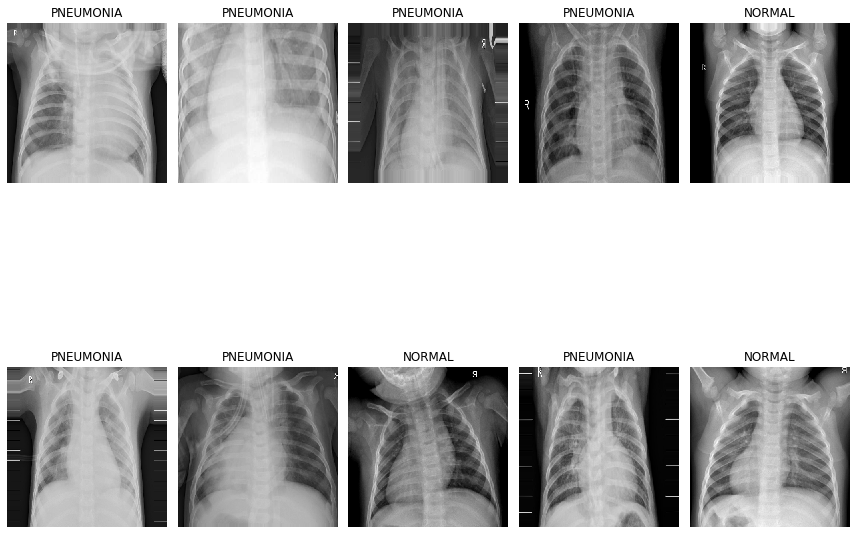

In [ ]:
# some of the train set images that we obtained from the Data Augmentation
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

## 4. Convolutional Neural Network

### 4.1 Necessary imports

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

### 4.2 CNN Architecture

In [ ]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())


cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0

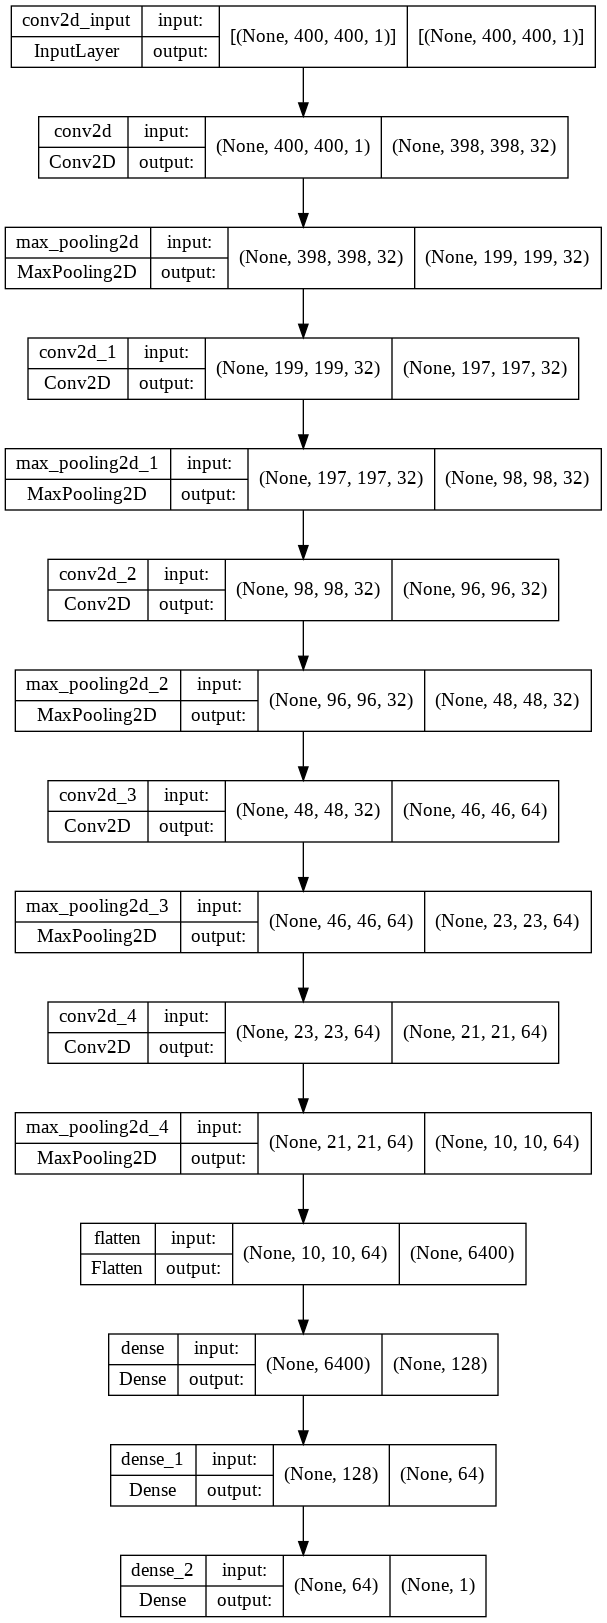

In [ ]:
# Visualize CNN model

from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

### 4.3 Fit the model

In [ ]:
# Defining Callback list
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
# Assigning Class Weights
# from sklearn.utils.class_weight import compute_class_weight
# weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
# cw = dict(zip( np.unique(train.classes), weights))
# print(cw)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train.classes), y= train.classes)
class_weights_dict = {i : class_weights[i] for i,label in enumerate(np.unique(train.classes))}
class_weights_dict

{0: 1.9371534195933457, 1: 0.6739549839228296}

In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=class_weights_dict, callbacks=callbacks_list)
# cnn.fit(train,epochs=15, validation_data=valid, class_weight=class_weights_dict)

# cnn.fit(train,epochs=10, validation_data=valid)

Epoch 1/25
131/131 [==============================] - 101s 658ms/step - loss: 0.4151 - accuracy: 0.7624 - val_loss: 0.1933 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 2/25
131/131 [==============================] - 89s 682ms/step - loss: 0.2179 - accuracy: 0.9113 - val_loss: 0.1808 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 3/25
131/131 [==============================] - 87s 663ms/step - loss: 0.1985 - accuracy: 0.9225 - val_loss: 0.1854 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 4/25
131/131 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9265
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 87s 663ms/step - loss: 0.1860 - accuracy: 0.9265 - val_loss: 0.1853 - val_accuracy: 0.9298 - lr: 0.0010
Epoch 5/25
131/131 [==============================] - 87s 662ms/step - loss: 0.1515 - accuracy: 0.9416 - val_loss: 0.1570 - val_accuracy: 0.9413 - lr: 3.0000e-04
Epoch 6/25
131/131 [========================

## 5. Evaluate

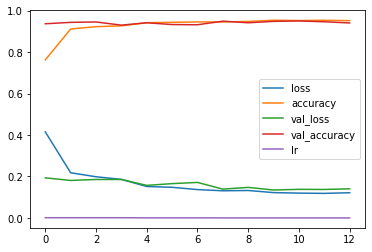

In [ ]:
# Let’s visualize the progress of all metrics throughout the total epochs lifetime
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

20/20 [==============================] - 7s 316ms/step - loss: 0.2688 - accuracy: 0.9151
The testing accuracy is : 91.50640964508057 %


The accuracy we are getting on Test dataset is of 91%

In [ ]:
preds = cnn.predict(test,verbose=1)

20/20 [==============================] - 6s 258ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

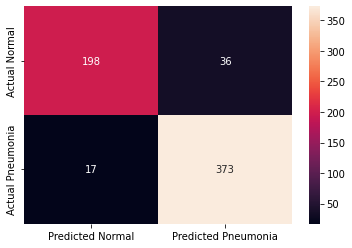

In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.92      0.85      0.88       234
   PNEUMONIA       0.91      0.96      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



(624, 400, 400, 1)
(624,)


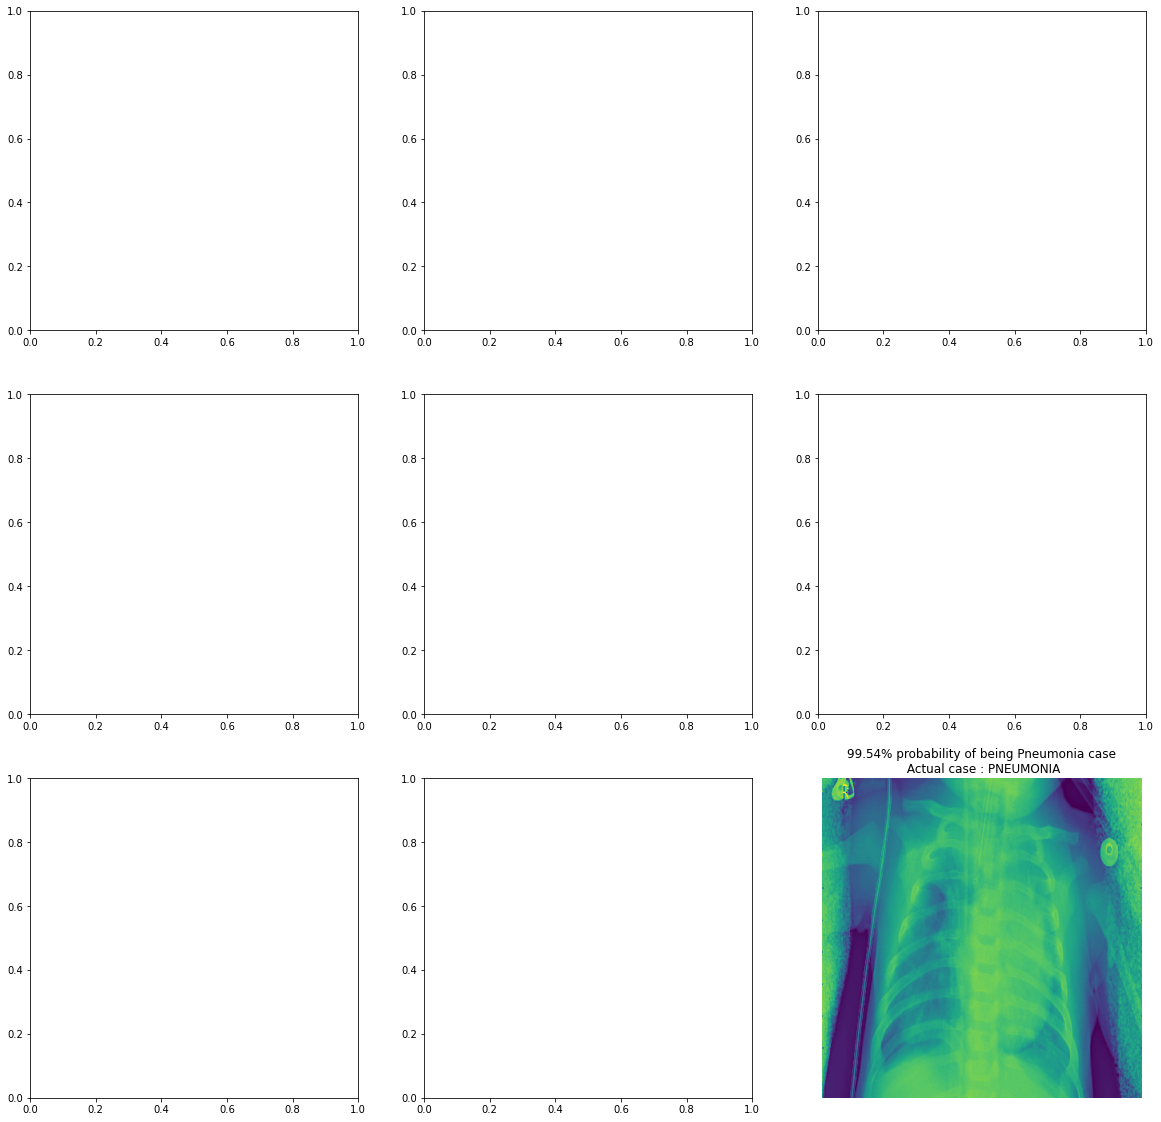

In [ ]:
# Let’s visualize some of the predicted images with percentage %

test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))

plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()

# Applying Transfer Learning Technique

### VGG16 Model

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

# add preprocessing layer to the front of VGG
# vgg = VGG16(input_shape=IMAGE_SIZE + [1], weights='imagenet', include_top=False)
vgg = VGG16(input_shape=IMAGE_SIZE + [1], weights=None, include_top=False)



In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
# folders = glob('Datasets/Train/*')
  
from tensorflow.keras.optimizers import SGD
# our layers - you can add more if you want
x = Flatten()(vgg.layers[-1].output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(1, activation='sigmoid')(prediction)
# define new model
vgg = Model(inputs=vgg.inputs, outputs=output)
# compile model
opt = SGD(lr=0.001, momentum=0.9)
vgg.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# create a model object
# model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
# model.compile(
#   loss='binary_crossentropy',
#   optimizer='adam',
#   metrics=['accuracy']
# )

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 color_mode='grayscale',
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            color_mode='grayscale',
                                            shuffle=False,
                                            batch_size = 32,
                                            class_mode = 'binary')

# valid_set = test_data_gen.flow_from_directory(
#       valid_path,
#       target_size=(img_height, img_width),
#       color_mode='grayscale',
#       class_mode='binary', 
#       batch_size=batch_size
#       )

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''


Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


'r=model.fit_generator(training_set,\n                         samples_per_epoch = 8000,\n                         nb_epoch = 5,\n                         validation_data = test_set,\n                         nb_val_samples = 2000)'

In [ ]:
# fit the model
r = vgg.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/5
131/131 [==============================] - 64s 460ms/step - loss: 0.6489 - accuracy: 0.7419 - val_loss: 0.6625 - val_accuracy: 0.6250
Epoch 2/5
131/131 [==============================] - 61s 463ms/step - loss: 0.5958 - accuracy: 0.7419 - val_loss: 0.6659 - val_accuracy: 0.6250
Epoch 3/5
131/131 [==============================] - 58s 439ms/step - loss: 0.5789 - accuracy: 0.7419 - val_loss: 0.6751 - val_accuracy: 0.6250
Epoch 4/5
131/131 [==============================] - 60s 454ms/step - loss: 0.5736 - accuracy: 0.7419 - val_loss: 0.6830 - val_accuracy: 0.6250
Epoch 5/5
131/131 [==============================] - 57s 437ms/step - loss: 0.5719 - accuracy: 0.7419 - val_loss: 0.6881 - val_accuracy: 0.6250


In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

# import tensorflow as tf

# from keras.models import load_model

# model.save('facefeatures_new_model.h5')